# Cleaning and EDA

## Imports/Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
# Pallete codes:
oxford_blue = (10/255, 35/255, 66/255)
timberwolf = (212/255, 210/255, 213/255)
silver = (191/255, 175/255, 166/255)
viridian = (91/255, 130/255, 102/255)
ebony_green = (86/255, 98/255, 70/255)
liver = (119/255, 81/255, 68/255)

full_palette = [oxford_blue, timberwolf, silver, viridian, ebony_green, liver]

### Read Data

In [4]:
df = pd.read_csv('data/source_data/TRAIN.csv')
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'store_id', 'store_type', 'location_type', 'region_code', 'date',
       'holiday', 'discount', '#order', 'sales'],
      dtype='object')

In [6]:
df.rename(columns={'#order': 'orders'}, inplace=True)

___

## Data Investigation

Data set represents daily sales by store location (365 stores) from Jan 1 2018 - May 31 2018. 68 holidays are present in the df.

Interesting things to analyze:
- Trends/Forecst in average order amount (Sales / #Order)
- How much does discount effect # orders and sales?
- Do stores perform better if they are a certain store type, location type, region?
- Are discounts more likely to be given on holidays? 
- Are discounts  more effective on holidays? 
- How do discounts effect # of orders, sales, and sales per order? 
- Do some regions, location types, store types offer more discounts than others?
- Are there ways to group or cluster stores with a combination of X variables?

### Summary Stats

In [7]:
df.describe()

,store_id,holiday,orders,sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


In [8]:
df.shape

(188340, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             188340 non-null  object 
 1   store_id       188340 non-null  int64  
 2   store_type     188340 non-null  object 
 3   location_type  188340 non-null  object 
 4   region_code    188340 non-null  object 
 5   date           188340 non-null  object 
 6   holiday        188340 non-null  int64  
 7   discount       188340 non-null  object 
 8   orders         188340 non-null  int64  
 9   sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


> Categorical Columns: 
  store_id, store_type, location_type, region_code, date, holiday, discount


> True numeric columns:
  order (and sales, our target variable)

### Map Discount to Binary

In [10]:
df['discount'] = np.where(df['discount']=='Yes', 1, 0)
df['discount'].value_counts()

0    104051
1     84289
Name: discount, dtype: int64

## Time Series Exploration

In [11]:
# years represented in the data
pd.to_datetime(df['date']).dt.year.value_counts()

2018    133225
2019     55115
Name: date, dtype: int64

In [12]:
# Number of unique dates represented in the data
df['date'].nunique()

516

In [13]:
# Number of unique stores represented in the data
df['store_id'].nunique()

365

In [14]:
# all stores have the same number of rows
pd.to_datetime(df.date).dt.date.value_counts().value_counts()

365    516
Name: date, dtype: int64

In [15]:
holidays = df[df['holiday'] == 1]
holidays = holidays['date'].unique()
print(f"There are {holidays.size} holidays in the data")

There are 68 holidays in the data


### Create Time Series

In [16]:
dt_df = df.copy()
dt_df.date = pd.to_datetime(dt_df.date)
grp_cols = ['date','id','store_id','store_type','location_type','region_code']

In [17]:
# Daily Data
daily = dt_df.groupby(grp_cols).agg(sum).reset_index()
daily.date.nunique()

516

In [18]:
daily.to_csv('data/clean_data/daily.csv', index=False)

In [19]:
# Monthly Data
monthly = dt_df.copy()
monthly.date = monthly.date.dt.strftime('%Y-%m')
monthly = monthly.groupby(grp_cols).agg(sum).reset_index()
monthly.date.nunique()

17

In [20]:
monthly.to_csv('data/clean_data/monthly.csv', index=False)

## Time Series Sales & Orders Plots: Daily and Monthly

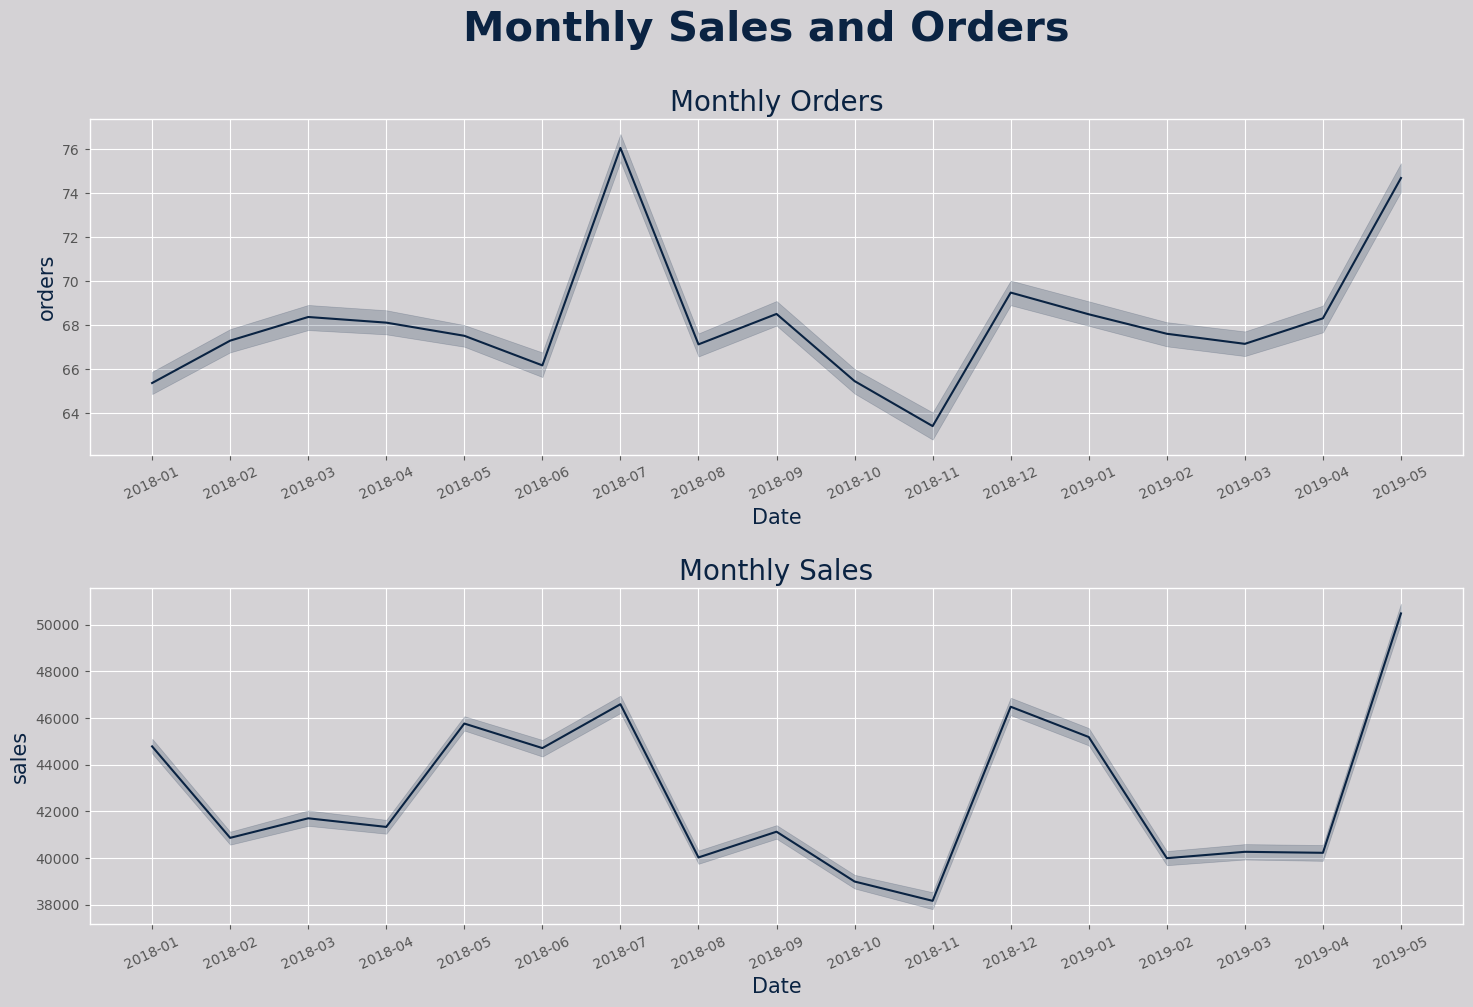

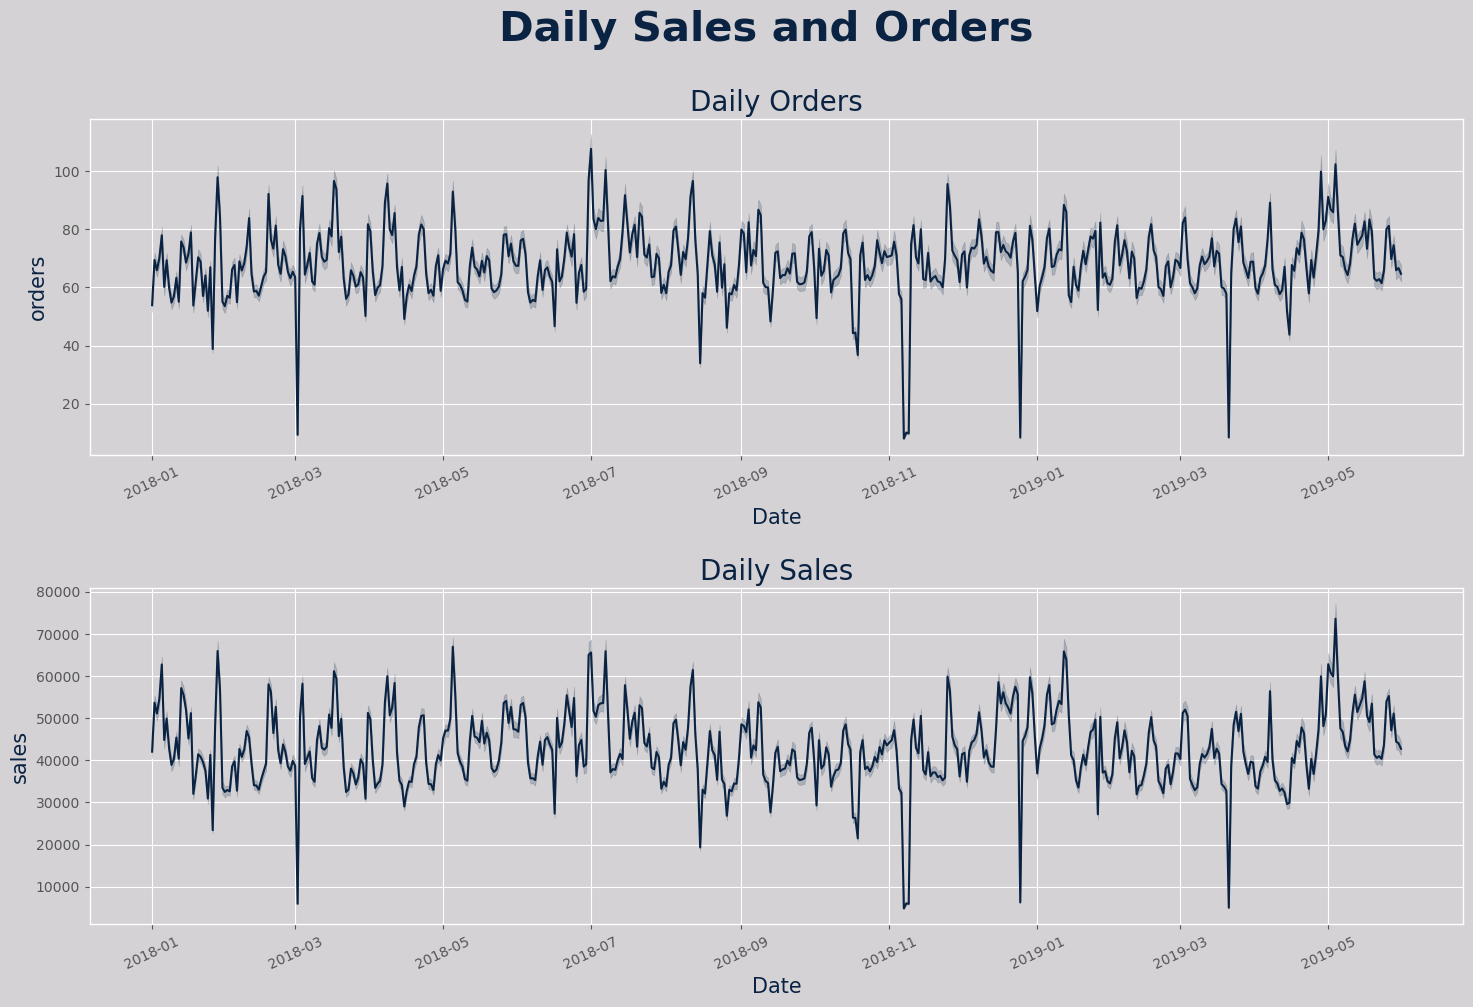

In [21]:
def plot_time_series(df, cols, titles, suptitle):
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    fig.set_facecolor(timberwolf)
    fig.suptitle(suptitle, fontsize=30, color=oxford_blue, fontweight='bold')
    fig.tight_layout(pad=3,h_pad=7.5,w_pad=2.5)
    for i, ax in enumerate(axes):
        ax.set_facecolor(timberwolf)
        ax.set_title(titles[i], fontsize=20, color=oxford_blue)
        ax.set_ylabel(cols[i], fontsize=15, color=oxford_blue)
        ax.set_xlabel('Date', fontsize=15, color=oxford_blue)
        sns.lineplot(x=df.date, y=cols[i], data=df, ax=ax, color=oxford_blue)
        ax.tick_params(axis='x', labelrotation=25)

plot_time_series(monthly, ['orders', 'sales'], ['Monthly Orders', 'Monthly Sales'], 'Monthly Sales and Orders')
plot_time_series(daily, ['orders', 'sales'], ['Daily Orders', 'Daily Sales'], 'Daily Sales and Orders')

___

### Store Type, Location Type, Region Code Distributions

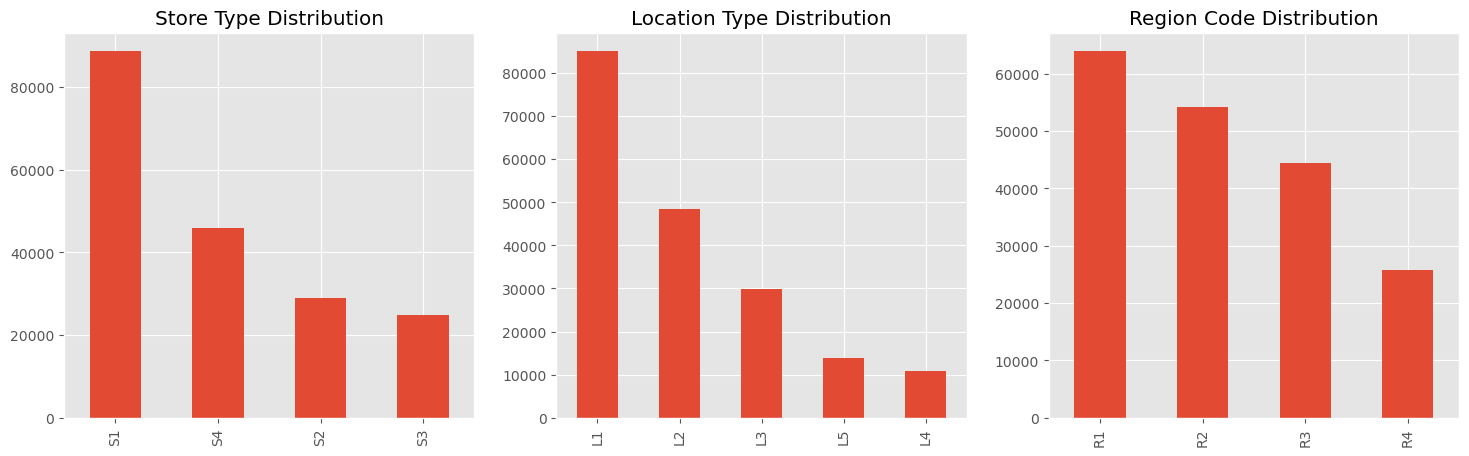

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

df['store_type'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Store Type Distribution')

df['location_type'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Location Type Distribution')

df['region_code'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('Region Code Distribution');

> It is worth mentioning that we have at least 10,000 observations for each `store type`, `location type`, and `region code`. This is a good amount of data to work with, especially since we'll be dummifying these variables later on.

## Exploring Sales Data

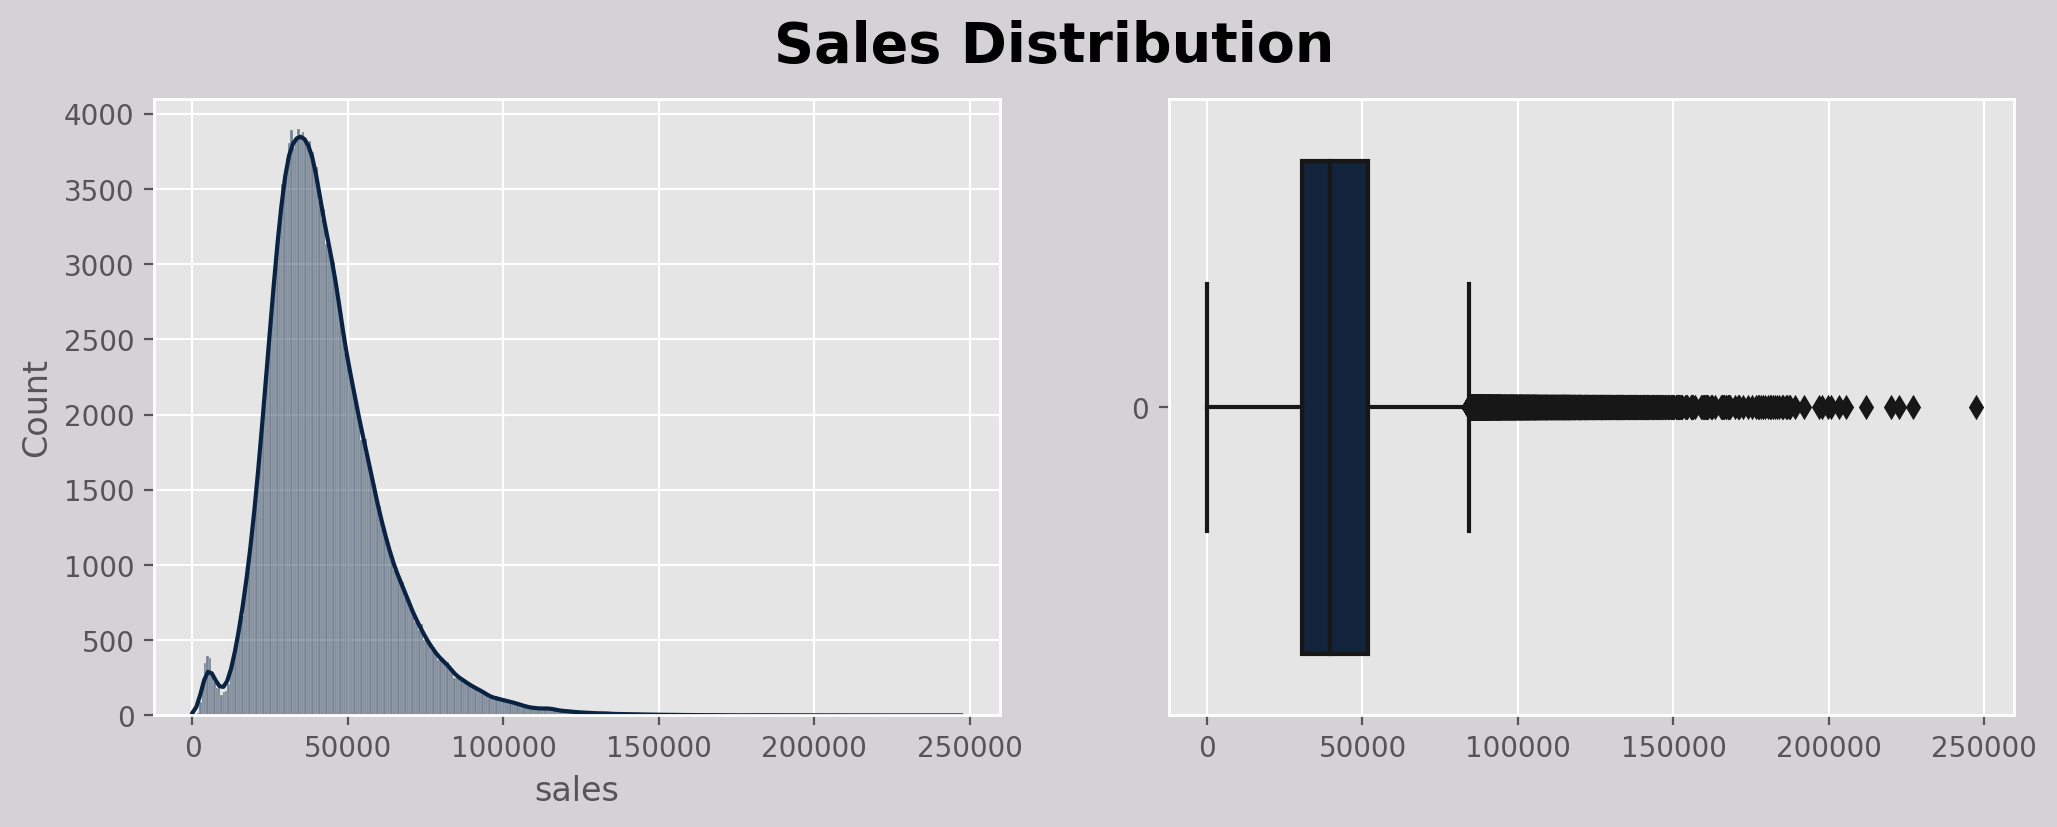

In [23]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=200)
sns.histplot(df['sales'], ax=ax1, kde=True, color=oxford_blue)
sns.boxplot(df['sales'], ax=ax2, orient='h', color=oxford_blue)
fig.suptitle('Sales Distribution', fontsize=20, fontweight='bold')
fig.set_facecolor(timberwolf);

> It appears we have some outliers in our data that are skewing our distribution! We've decided to keep these outliers in our data for now as we belive it will make our model more robust. We will revisit this decision later on.

#### Optional: Remove Outliers

In [24]:
q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1
df_out = df[(df["sales"] >= q1 - 1.5 * iqr) & (df["sales"] <= q3 + 1.5 * iqr)]

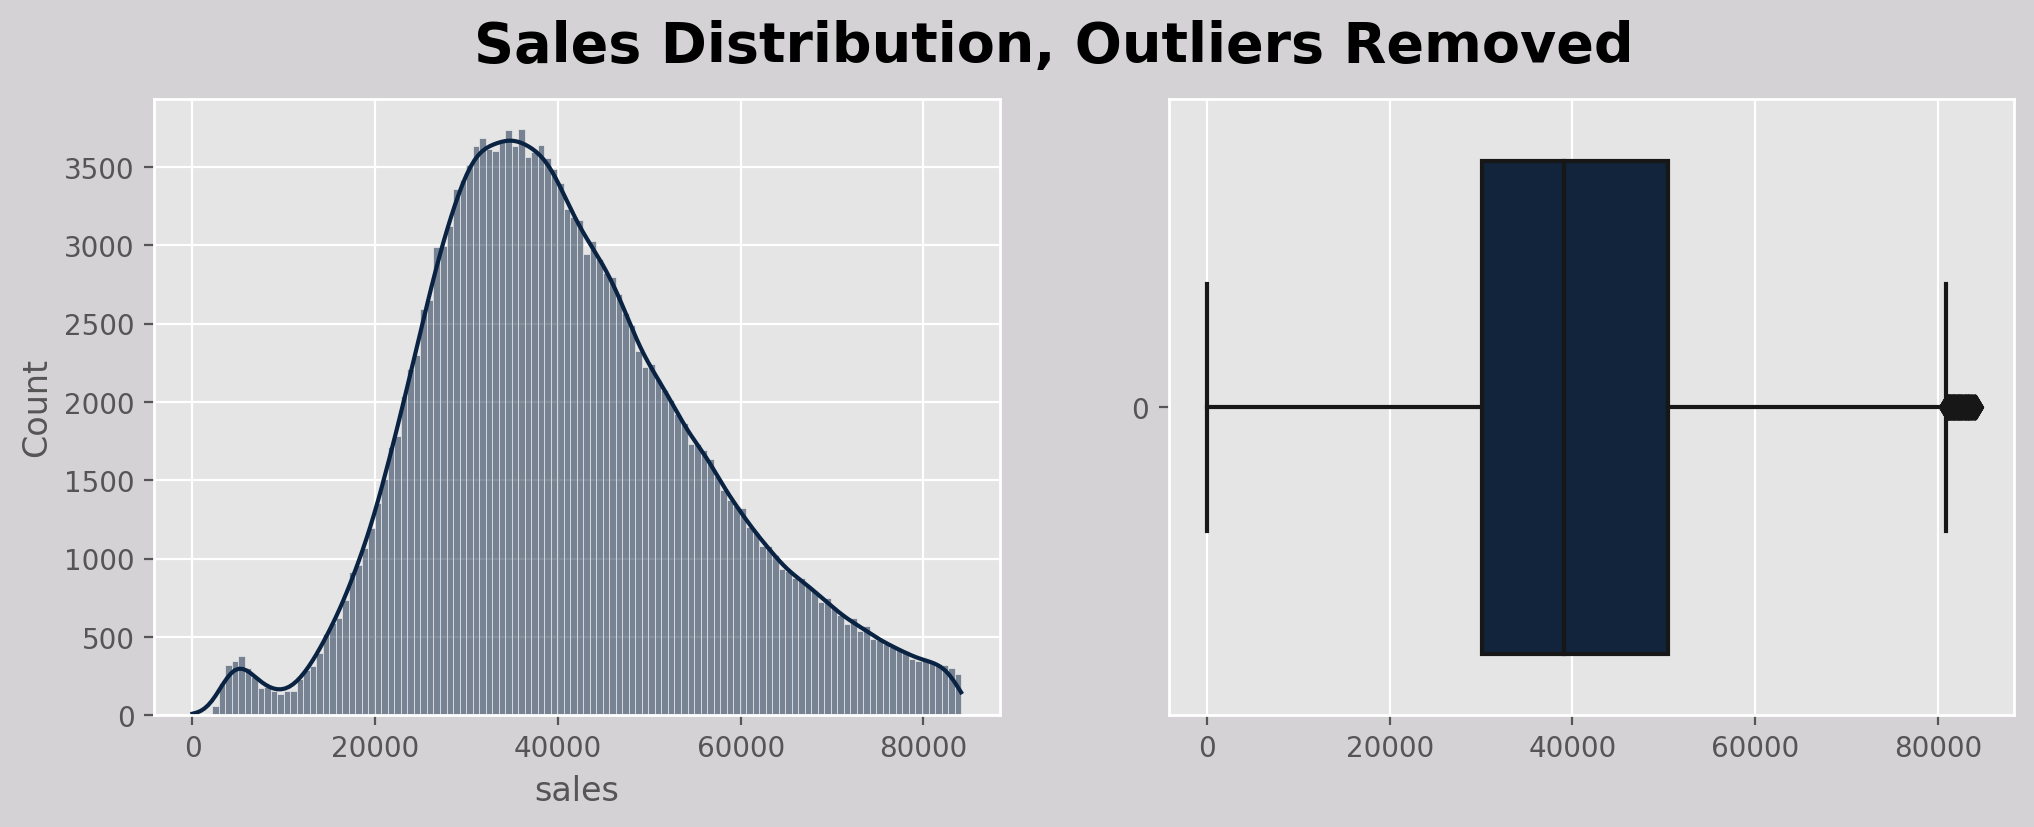

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=200)
sns.histplot(df_out['sales'], ax=ax1, kde=True, color=oxford_blue)
sns.boxplot(df_out['sales'], ax=ax2, orient='h', color=oxford_blue)
fig.suptitle('Sales Distribution, Outliers Removed', fontsize=20, fontweight='bold')
fig.set_facecolor(timberwolf);

##### We'd expect the ```orders``` distribution to be similar in shape to these as well due to their high correlation

___

### Target-CORR Heatmap

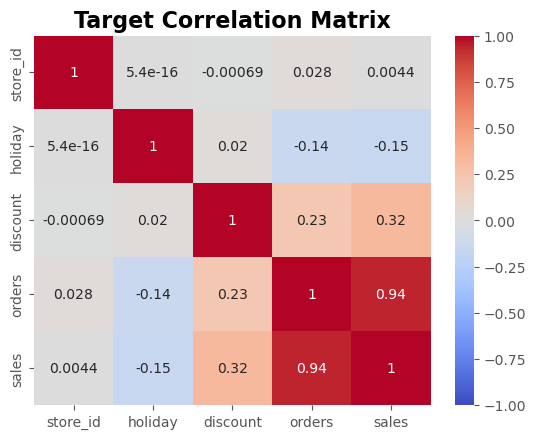

In [26]:
plt.title('Target Correlation Matrix', fontsize=16, fontweight='bold')
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1);

> We have a really strong relationship between the order and sales variables. A relationship between one of our features and the target variable is good in that it means we have a good chance of predicting the target variable with our model. However, orders might also be something we want to predict and wouldn't likely be something we know ahead of time when making future predictions about sales. We will revisit this later on. 

___

### Sales vs. Orders

Taking a look at the correlation more closely...

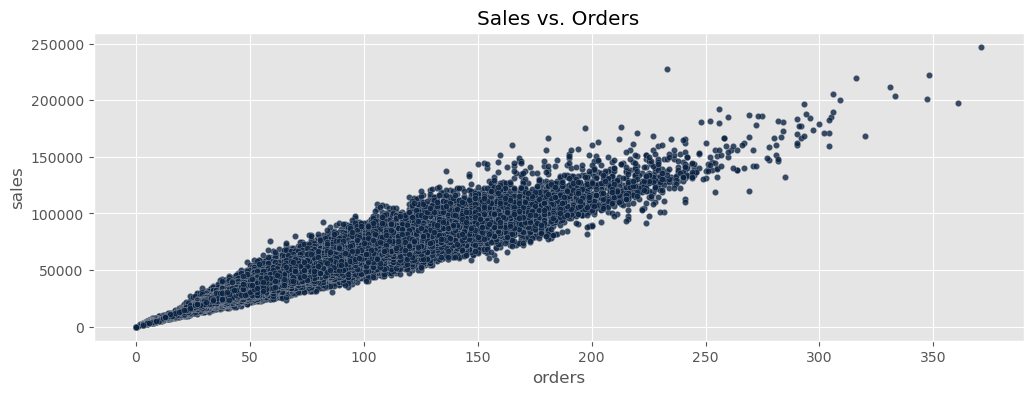

In [27]:
df.plot(kind='scatter', x='orders', y='sales', figsize=(12,4), color=oxford_blue, title='Sales vs. Orders',
        edgecolor=timberwolf, linewidth=0.2, s=20, alpha=0.8);

> As we saw, orders have a positive, nearly perfectly linear relationship with sales.

___

### Sales Averages by Store Type, Location Type, Region Code

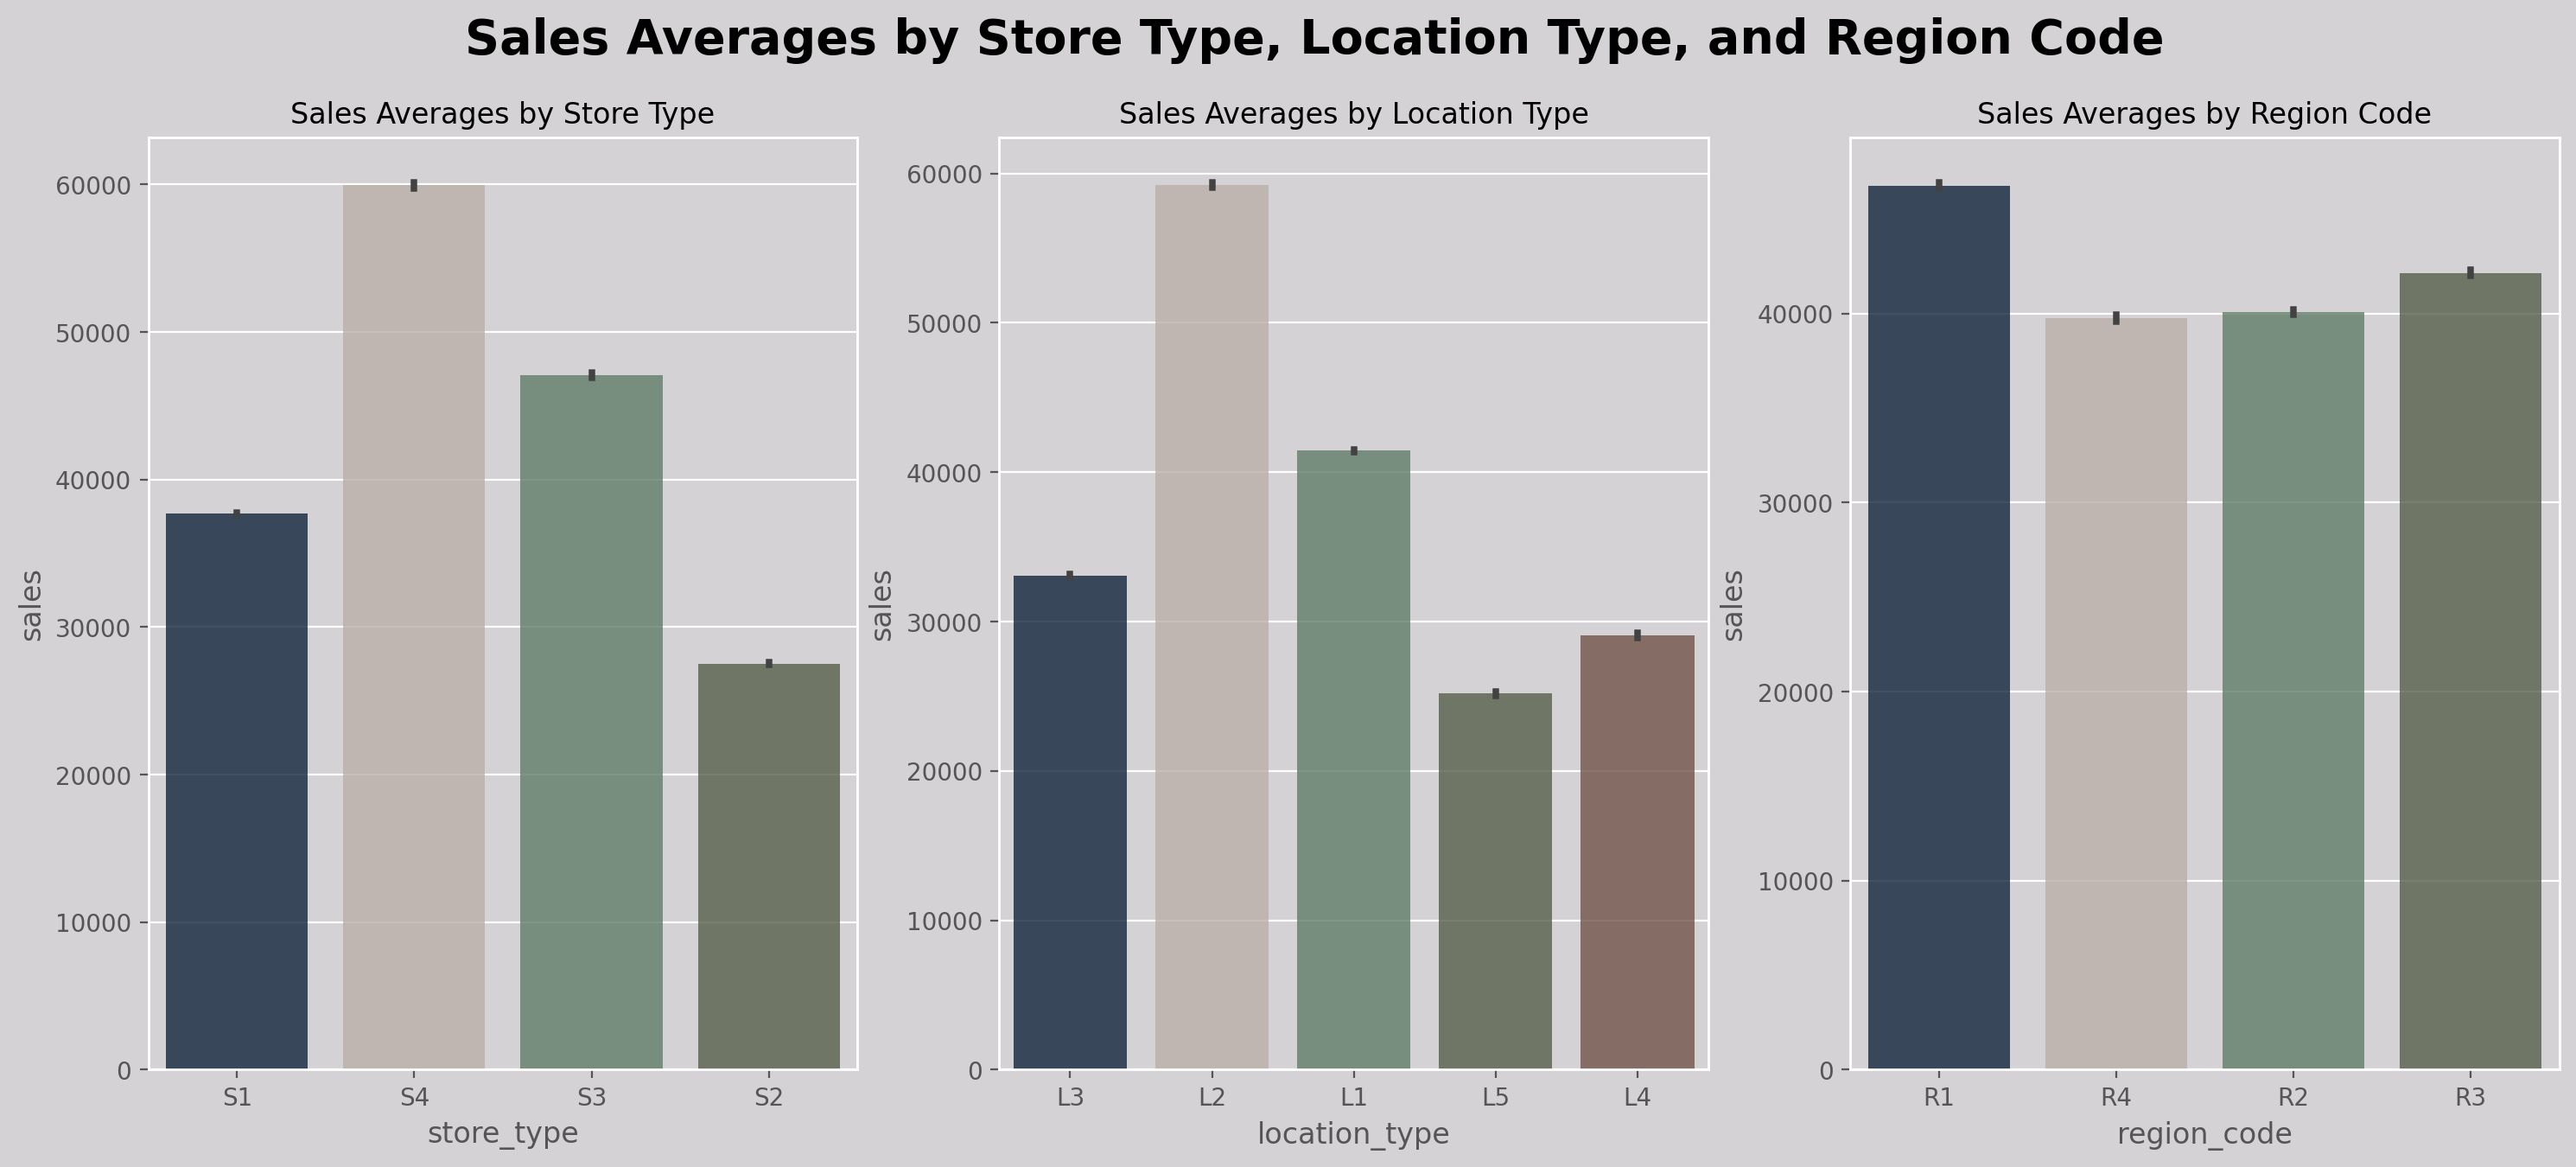

In [28]:
def plot_sales_averages(df, cols):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7), dpi=200)
    fig.suptitle('Sales Averages by Store Type, Location Type, and Region Code', fontsize=20, fontweight='bold')
    fig.set_facecolor(timberwolf)
    # fig.set_tight_layout(True)
    for i, ax in enumerate(axes):
        ax.sharey = True
        ax.set_title(f"Sales Averages by {cols[i].replace('_', ' ').title()}", fontsize=12)
        ax.set_facecolor(timberwolf)
        sns.barplot(x=cols[i], y='sales', data=df, ax=ax, palette=[oxford_blue, silver, viridian, ebony_green, liver], alpha=0.8)

plot_sales_averages(df, ['store_type', 'location_type', 'region_code'])

#### Interpreting the Results:

These graphs give us reason to believe that S4, L2, and R1 will be significant factors in determining the overall monthly sales of a store, potentially daily sales as well. We will explore this further in the next section.

____

## Discount Data

In [29]:
df.groupby('discount')['orders'].mean()

discount
0    61.806153
1    76.105637
Name: orders, dtype: float64

> Looks like adding discounts results in more orders, though we can't assert causation here quite yet. We'll explore this further in the modeling phase of the study.

In [30]:
df.groupby('discount')['sales'].mean()

discount
0    37403.679678
1    49426.497620
Name: sales, dtype: float64

> Expectedly, adding discounts is also associated with more sales.